# Deal with bureau & bureau_balance dataset

+ bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
+ bureau_balance: monthly information about the previous loans. Each month has its own row.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

# Bureau Dataset

In [3]:
bureau = pd.read_csv('../home-credit-default-risk/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Counts of A Clients's Previous Loans

In [19]:
previous_loan_counts = pd.DataFrame(bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count())
previous_loan_counts.columns = ['previous_loan_counts']
previous_loan_counts.reset_index(inplace = True)

In [25]:
previous_loan_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 2 columns):
SK_ID_CURR              305811 non-null int64
previous_loan_counts    305811 non-null int64
dtypes: int64(2)
memory usage: 4.7 MB


In [27]:
train = pd.read_csv('../home-credit-default-risk/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

## Assessing Usefulness of Variables

In [28]:
def kde_target(var_name, df):
    corr = df['TARGET'].corr(df[var_name])
    
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()

    plt.figure(figsize = (12,6))
    
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'Default')
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'Not Default')

    plt.xlabel(var_name)
    plt.ylabel('Desnsity')
    plt.title('{} Distribution'.format(var_name))
    plt.legend()
    plt.show()
    
    print('The correlation between {} and the TARGET is {:.4f}'.format(var_name,corr))
    print('Median value for loan that was default = {:.4f}'.format(avg_not_repaid))
    print('Median value for loan that was not default = {:.4f}'.format(avg_repaid))

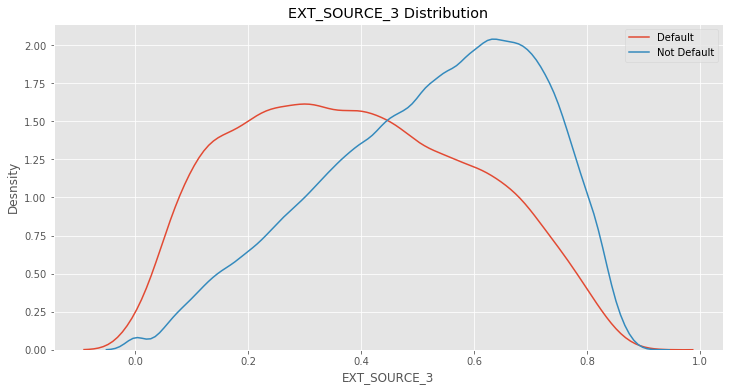

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was default = 0.3791
Median value for loan that was not default = 0.5460


In [29]:
kde_target('EXT_SOURCE_3', train)

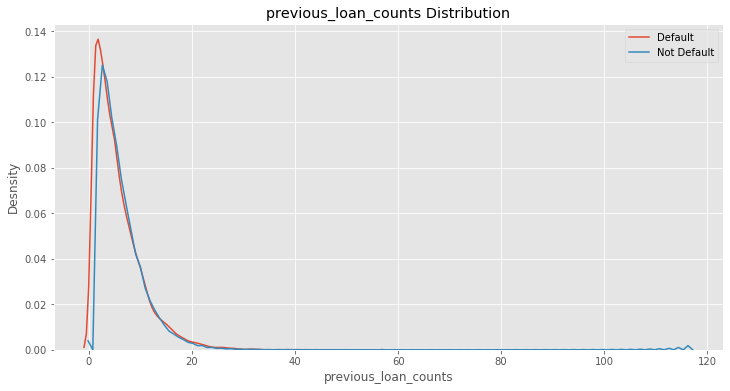

The correlation between previous_loan_counts and the TARGET is 0.0041
Median value for loan that was default = 4.0000
Median value for loan that was not default = 4.0000


In [31]:
kde_target('previous_loan_counts',train)

Shows little relationship

## Aggregating Numeric Columns

In [32]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [42]:
col_name = [column[0] + '_' + column[1] for column in list(bureau_agg.columns)]
col_name[0] = col_name[0][:-1]

In [45]:
bureau_agg.columns = col_name

In [46]:
bureau_agg

,SK_ID_CURR,DAYS_CREDIT_count,DAYS_CREDIT_mean,DAYS_CREDIT_max,DAYS_CREDIT_min,DAYS_CREDIT_sum,CREDIT_DAY_OVERDUE_count,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_max,CREDIT_DAY_OVERDUE_min,...,DAYS_CREDIT_UPDATE_count,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_max,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_sum,AMT_ANNUITY_count,AMT_ANNUITY_mean,AMT_ANNUITY_max,AMT_ANNUITY_min,AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.000,24817.500
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.000,0.000
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.000
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.000
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.000,4261.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,13,-1667.076923,-483,-2713,-21672,13,0.0,0,0,...,13,-1064.538462,-12,-2498,-13839,0,NaN,NaN,NaN,0.000
305807,456250,3,-862.000000,-760,-1002,-2586,3,0.0,0,0,...,3,-60.333333,-23,-127,-181,3,154567.965000,384147.0,27757.395,463703.895
305808,456253,4,-867.500000,-713,-919,-3470,4,0.0,0,0,...,4,-253.250000,-5,-701,-1013,3,58369.500000,58369.5,58369.500,175108.500
305809,456254,1,-1104.000000,-1104,-1104,-1104,1,0.0,0,0,...,1,-401.000000,-401,-401,-401,1,0.000000,0.0,0.000,0.000


In [47]:
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DAYS_CREDIT_UPDATE_count,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_max,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_sum,AMT_ANNUITY_count,AMT_ANNUITY_mean,AMT_ANNUITY_max,AMT_ANNUITY_min,AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


In [52]:
train.corr()['TARGET'].abs()[col_name].sort_values(ascending = False)[:15]

DAYS_CREDIT_mean            0.089729
DAYS_CREDIT_min             0.075248
DAYS_CREDIT_UPDATE_mean     0.068927
DAYS_ENDDATE_FACT_min       0.055887
DAYS_CREDIT_ENDDATE_sum     0.053735
DAYS_ENDDATE_FACT_mean      0.053200
DAYS_CREDIT_max             0.049782
DAYS_ENDDATE_FACT_sum       0.048854
DAYS_CREDIT_ENDDATE_mean    0.046983
DAYS_CREDIT_UPDATE_min      0.042864
DAYS_CREDIT_sum             0.042000
DAYS_CREDIT_UPDATE_sum      0.041404
DAYS_CREDIT_ENDDATE_max     0.036590
DAYS_CREDIT_ENDDATE_min     0.034281
DAYS_ENDDATE_FACT_count     0.030492
Name: TARGET, dtype: float64

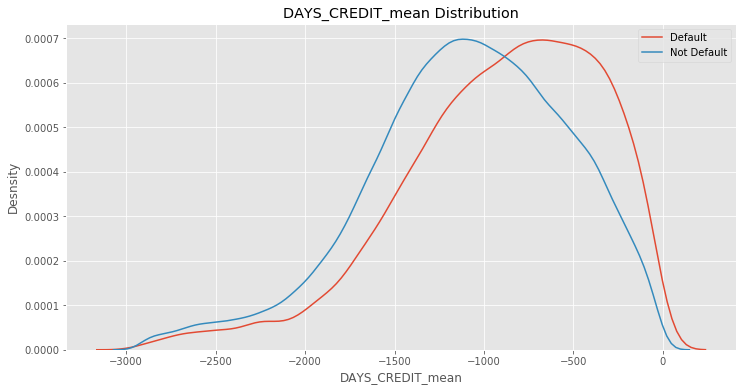

The correlation between DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was default = -835.3333
Median value for loan that was not default = -1067.0000


In [53]:
kde_target('DAYS_CREDIT_mean',train)

### Function for Numerical Aggregation
encapsulate all of the previoud work  
Could be used in further preprocess

In [54]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [55]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [62]:
def target_corrs(df):
    col = df.columns
    col = col.drop('TARGET')
    return df.corr()['TARGET'].abs()[col].sort_values(ascending = False)

In [63]:
target_corrs(train)

EXT_SOURCE_3           0.178919
EXT_SOURCE_2           0.160472
EXT_SOURCE_1           0.155317
DAYS_CREDIT_mean       0.089729
DAYS_BIRTH             0.078239
                         ...   
ORGANIZATION_TYPE           NaN
FONDKAPREMONT_MODE          NaN
HOUSETYPE_MODE              NaN
WALLSMATERIAL_MODE          NaN
EMERGENCYSTATE_MODE         NaN
Name: TARGET, Length: 182, dtype: float64

## Categorical Variables

In [65]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [67]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum','mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [70]:
col_name = [column[0] + '_' + column[1] for column in list(categorical_grouped.columns)]
categorical_grouped.columns = col_name

In [72]:
categorical_grouped.head()

,CREDIT_ACTIVE_Active_sum,CREDIT_ACTIVE_Active_mean,CREDIT_ACTIVE_Bad debt_sum,CREDIT_ACTIVE_Bad debt_mean,CREDIT_ACTIVE_Closed_sum,CREDIT_ACTIVE_Closed_mean,CREDIT_ACTIVE_Sold_sum,CREDIT_ACTIVE_Sold_mean,CREDIT_CURRENCY_currency 1_sum,CREDIT_CURRENCY_currency 1_mean,...,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [73]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_sum,CREDIT_TYPE_Microloan_mean,CREDIT_TYPE_Mobile operator loan_sum,CREDIT_TYPE_Mobile operator loan_mean,CREDIT_TYPE_Mortgage_sum,CREDIT_TYPE_Mortgage_mean,CREDIT_TYPE_Real estate loan_sum,CREDIT_TYPE_Real estate loan_mean,CREDIT_TYPE_Unknown type of loan_sum,CREDIT_TYPE_Unknown type of loan_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Functions to Handle Categorical Variables

In [74]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [75]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


# Bureau Balance Dataset

In [76]:
bureau_balance = pd.read_csv('../home-credit-default-risk/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [78]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [98]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [83]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU','SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_STATUS_0_count_x,bureau_balance_STATUS_0_count_norm_x,bureau_balance_STATUS_1_count_x,bureau_balance_STATUS_1_count_norm_x,bureau_balance_STATUS_2_count_x,bureau_balance_STATUS_2_count_norm_x,bureau_balance_STATUS_3_count_x,bureau_balance_STATUS_3_count_norm_x,bureau_balance_STATUS_4_count_x,...,bureau_balance_STATUS_3_count_norm_y,bureau_balance_STATUS_4_count_y,bureau_balance_STATUS_4_count_norm_y,bureau_balance_STATUS_5_count_y,bureau_balance_STATUS_5_count_norm_y,bureau_balance_STATUS_C_count_y,bureau_balance_STATUS_C_count_norm_y,bureau_balance_STATUS_X_count_y,bureau_balance_STATUS_X_count_norm_y,SK_ID_CURR
0,5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [84]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_STATUS_0_count_x_count,client_bureau_balance_STATUS_0_count_x_mean,client_bureau_balance_STATUS_0_count_x_max,client_bureau_balance_STATUS_0_count_x_min,client_bureau_balance_STATUS_0_count_x_sum,client_bureau_balance_STATUS_0_count_norm_x_count,client_bureau_balance_STATUS_0_count_norm_x_mean,client_bureau_balance_STATUS_0_count_norm_x_max,client_bureau_balance_STATUS_0_count_norm_x_min,...,client_bureau_balance_STATUS_X_count_y_count,client_bureau_balance_STATUS_X_count_y_mean,client_bureau_balance_STATUS_X_count_y_max,client_bureau_balance_STATUS_X_count_y_min,client_bureau_balance_STATUS_X_count_y_sum,client_bureau_balance_STATUS_X_count_norm_y_count,client_bureau_balance_STATUS_X_count_norm_y_mean,client_bureau_balance_STATUS_X_count_norm_y_max,client_bureau_balance_STATUS_X_count_norm_y_min,client_bureau_balance_STATUS_X_count_norm_y_sum
0,100001.0,7,4.428571,12,1,31.0,7,0.336651,1.000000,0.019231,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,5.625000,18,2,45.0,8,0.406960,0.818182,0.187500,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,4.666667,7,2,14.0,3,0.735043,1.000000,0.538462,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,10.000000,10,10,20.0,2,0.277778,0.277778,0.277778,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,19.750000,34,0,79.0,4,0.320718,0.618182,0.000000,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


for the bureau_balance dataframe we:

+ Calculated numeric stats grouping by each loan
+ Made value counts of each categorical variable grouping by loan
+ Merged the stats and the value counts on the loans
+ Calculated numeric stats for the resulting dataframe grouping by the client id

# Putting the Function Together

In [85]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

71264

In [102]:
train = pd.read_csv('../home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('../home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../home-credit-default-risk/bureau_balance.csv')

In [87]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [88]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [89]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [99]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [100]:
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU','SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [101]:
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


In [103]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [104]:
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [105]:
new_features = list(train.columns)
print('Number of Features using previoous loans from other institutions data: ', len(new_features))

Number of Features using previoous loans from other institutions data:  333


# Feauture Engineering Outcome

## Missing Values

In [109]:
missing_values = train.isna().sum(axis=0).reset_index()
missing_values.columns = ['Variables','Missing Values'] 
missing_values = missing_values[missing_values['Missing Values'] > 0]
missing_values['% of Total Values'] = missing_values['Missing Values']/train.shape[0]*100
missing_values.sort_values('% of Total Values', ascending=False)[:10]

,Variables,Missing Values,% of Total Values
226,bureau_AMT_ANNUITY_min,227502,73.981744
225,bureau_AMT_ANNUITY_max,227502,73.981744
224,bureau_AMT_ANNUITY_mean,227502,73.981744
332,client_bureau_balance_STATUS_X_count_norm_sum,215280,70.007252
276,client_bureau_balance_STATUS_2_count_min,215280,70.007252
283,client_bureau_balance_STATUS_3_count_count,215280,70.007252
282,client_bureau_balance_STATUS_2_count_norm_sum,215280,70.007252
281,client_bureau_balance_STATUS_2_count_norm_min,215280,70.007252
280,client_bureau_balance_STATUS_2_count_norm_max,215280,70.007252
279,client_bureau_balance_STATUS_2_count_norm_mean,215280,70.007252


## Test Data

In [110]:
test = pd.read_csv('../home-credit-default-risk/application_test.csv')
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [113]:
train_labels = train['TARGET']
print('Shape of Training Data:', train.shape)
print('Shape of Testing Data: ',test.shape)

Shape of Training Data: (307511, 333)
Shape of Testing Data:  (48744, 332)


In [114]:
missing_values = test.isna().sum(axis=0).reset_index()
missing_values.columns = ['Variables','Missing Values'] 
missing_values = missing_values[missing_values['Missing Values'] > 0]
missing_values['% of Total Values'] = missing_values['Missing Values']/test.shape[0]*100
missing_values.sort_values('% of Total Values', ascending=False)[:10]

,Variables,Missing Values,% of Total Values
75,COMMONAREA_MEDI,33495,68.716150
61,COMMONAREA_MODE,33495,68.716150
47,COMMONAREA_AVG,33495,68.716150
83,NONLIVINGAPARTMENTS_MEDI,33347,68.412523
55,NONLIVINGAPARTMENTS_AVG,33347,68.412523
69,NONLIVINGAPARTMENTS_MODE,33347,68.412523
85,FONDKAPREMONT_MODE,32797,67.284179
81,LIVINGAPARTMENTS_MEDI,32780,67.249302
53,LIVINGAPARTMENTS_AVG,32780,67.249302
67,LIVINGAPARTMENTS_MODE,32780,67.249302


In [115]:
# train.to_csv('../home-credit-default-risk/train_bureau_raw.csv', index = False)
# test.to_csv('../home-credit-default-risk/test_bureau_raw.csv', index = False)

In [117]:
target_corrs(train)[:20]

EXT_SOURCE_3                                       0.178919
EXT_SOURCE_2                                       0.160472
EXT_SOURCE_1                                       0.155317
bureau_DAYS_CREDIT_mean                            0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean      0.089038
client_bureau_balance_MONTHS_BALANCE_count_mean    0.080193
bureau_CREDIT_ACTIVE_Closed_count_norm             0.079369
DAYS_BIRTH                                         0.078239
bureau_CREDIT_ACTIVE_Active_count_norm             0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean     0.076424
bureau_DAYS_CREDIT_min                             0.075248
client_bureau_balance_MONTHS_BALANCE_min_min       0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean      0.072606
bureau_DAYS_CREDIT_UPDATE_mean                     0.068927
client_bureau_balance_MONTHS_BALANCE_count_max     0.068792
client_bureau_balance_MONTHS_BALANCE_sum_min       0.068072
bureau_CREDIT_ACTIVE_Active_count       

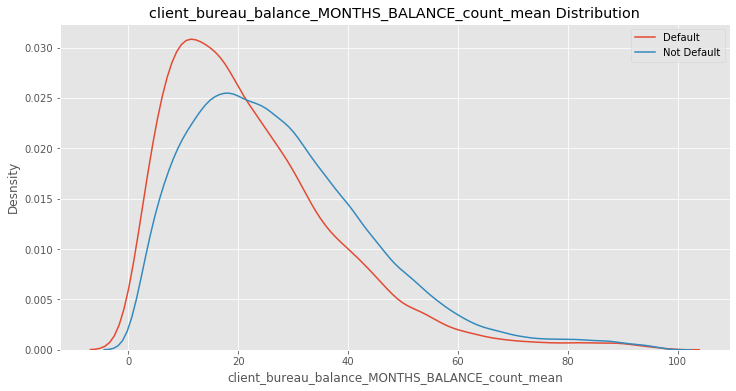

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.0802
Median value for loan that was default = 19.3333
Median value for loan that was not default = 25.1429


In [119]:
kde_target('client_bureau_balance_MONTHS_BALANCE_count_mean', train)

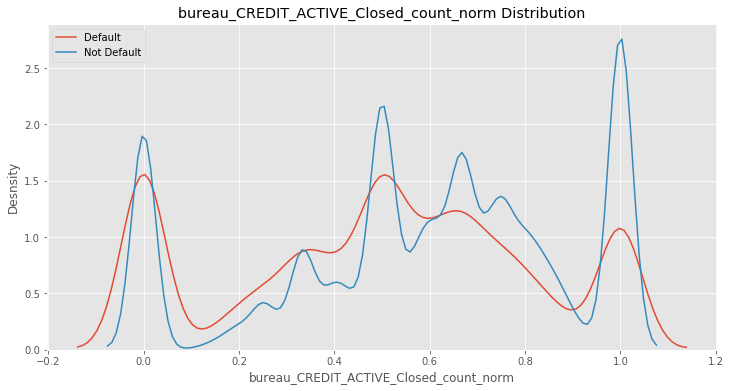

The correlation between bureau_CREDIT_ACTIVE_Closed_count_norm and the TARGET is -0.0794
Median value for loan that was default = 0.5000
Median value for loan that was not default = 0.6250


In [120]:
kde_target('bureau_CREDIT_ACTIVE_Closed_count_norm', train)

## Remove Highly Collinear Variables

In [124]:
threshold = 0.8

above_threshold_vars = {}

corrs = train.corr()

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [127]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key,value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
                
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ',len(cols_to_remove))

Number of columns to remove:  133


In [143]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 200)
Testing Corrs Removed Shape:  (48744, 199)


# Model

In [130]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [131]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [132]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

### Control

In [133]:
train_control = pd.read_csv('../home-credit-default-risk/application_train.csv')
test_control = pd.read_csv('../home-credit-default-risk/application_test.csv')

In [134]:
submission, fi, metrics = model(train_control,test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798103	train's binary_logloss: 0.548552	valid's auc: 0.760007	valid's binary_logloss: 0.561913
Early stopping, best iteration is:
[269]	train's auc: 0.809199	train's binary_logloss: 0.537755	valid's auc: 0.760273	valid's binary_logloss: 0.555207
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798328	train's binary_logloss: 0.54852	valid's auc: 0.76114	valid's binary_logloss: 0.566651
Early stopping, best iteration is:
[289]	train's auc: 0.812654	train's binary_logloss: 0.534422	valid's auc: 0.761398	valid's binary_logloss: 0.558103
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.79964	train's binary_logloss: 0.54685	valid's auc: 0.750232	valid's binary_logloss: 0.564639
Early stopping, best iteration is:
[265]	train's auc: 0.809734	train's binary_logloss: 0.53678	val

In [135]:
metrics

,fold,train,valid
0,0,0.809199,0.760273
1,1,0.812654,0.761398
2,2,0.809734,0.750451
3,3,0.811121,0.760245
4,4,0.802236,0.760972
5,overall,0.808989,0.758635


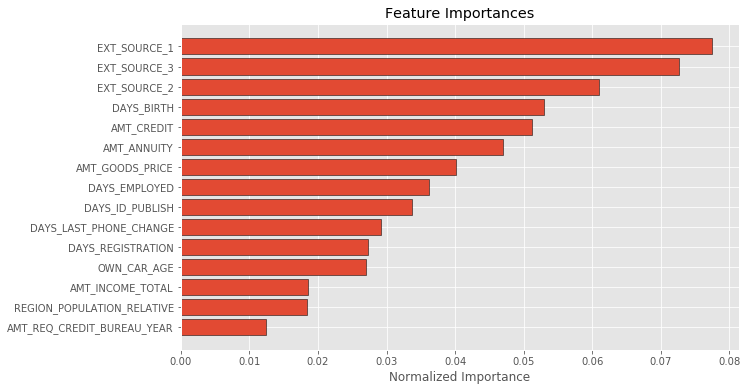

In [136]:
fi_sorted = plot_feature_importances(fi)

In [137]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 452)
Testing Data Shape:  (48744, 452)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810646	train's binary_logloss: 0.536749	valid's auc: 0.76652	valid's binary_logloss: 0.552522
[400]	train's auc: 0.843527	train's binary_logloss: 0.503074	valid's auc: 0.766727	valid's binary_logloss: 0.531654
Early stopping, best iteration is:
[305]	train's auc: 0.829247	train's binary_logloss: 0.517933	valid's auc: 0.767034	valid's binary_logloss: 0.540854
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.810143	train's binary_logloss: 0.5372	valid's auc: 0.767352	valid's binary_logloss: 0.556961
[400]	train's auc: 0.843873	train's binary_logloss: 0.502684	valid's auc: 0.767776	valid's binary_logloss: 0.535539
Early stopping, best iteration is:
[307]	train's auc: 0.829766	train's binary_logloss: 0.517371	valid's auc: 0.76805	valid's binary_logloss: 0.544695
Training until validation scores don't impro

In [138]:
metrics_raw

,fold,train,valid
0,0,0.829247,0.767034
1,1,0.829766,0.768050
2,2,0.823651,0.760996
3,3,0.830550,0.768341
4,4,0.833314,0.768051
5,overall,0.829306,0.766507


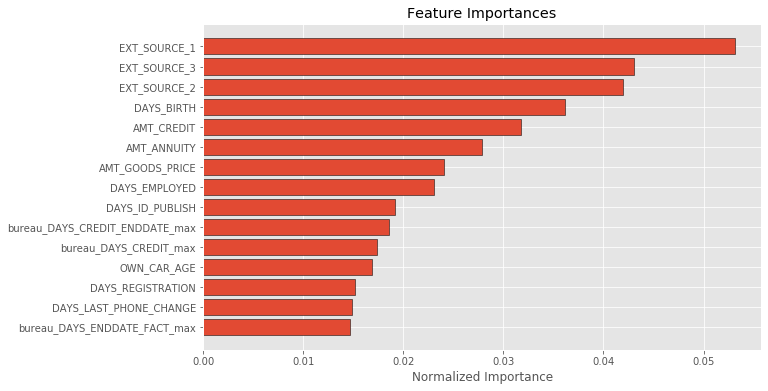

In [139]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [140]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('{}% of Top 100 Features created from the bureau data'.format(len(new_features)))

52% of Top 100 Features created from the bureau data


In [145]:
submission_corrs, fi_corrs, metrics_corrs = model(train_corrs_removed, test_corrs_removed)

Training Data Shape:  (307511, 319)
Testing Data Shape:  (48744, 319)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806243	train's binary_logloss: 0.540993	valid's auc: 0.764101	valid's binary_logloss: 0.555781
[400]	train's auc: 0.838461	train's binary_logloss: 0.508643	valid's auc: 0.764047	valid's binary_logloss: 0.535553
Early stopping, best iteration is:
[319]	train's auc: 0.826678	train's binary_logloss: 0.520614	valid's auc: 0.764809	valid's binary_logloss: 0.542993
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806511	train's binary_logloss: 0.540677	valid's auc: 0.764447	valid's binary_logloss: 0.559868
Early stopping, best iteration is:
[298]	train's auc: 0.823683	train's binary_logloss: 0.523625	valid's auc: 0.764961	valid's binary_logloss: 0.549271
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.80785	train's binary_logloss: 0.53909	valid's auc: 0.756691	valid's binar

In [146]:
metrics_corrs

,fold,train,valid
0,0,0.826678,0.764809
1,1,0.823683,0.764961
2,2,0.814622,0.756971
3,3,0.817571,0.764854
4,4,0.824461,0.764522
5,overall,0.821403,0.763233


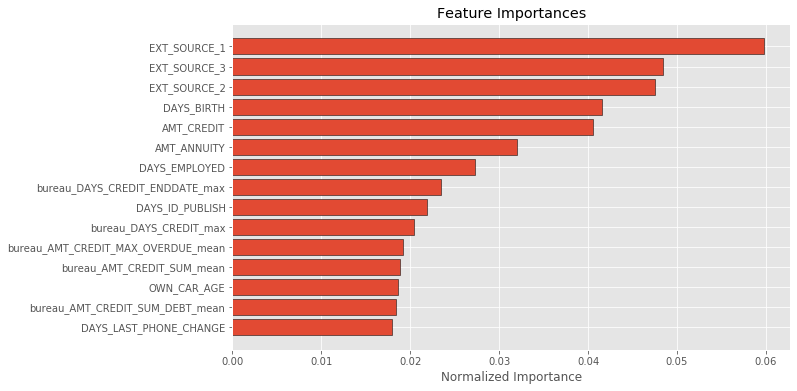

In [147]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)